## 0. 코랩 구동을 위한 설정

#### 0.1 모듈설치

In [1]:
!pip install konlpy
!pip install pyLDAvis
!pip install -U gensim

Requirement already up-to-date: gensim in c:\users\nk\anaconda3\lib\site-packages (3.8.3)


#### 0.2 모듈 불러오기

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.palettes import brewer
import re
import time

from konlpy.tag import Okt, Hannanum
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from tqdm import tqdm


import os.path
import pickle

import logging

%matplotlib inline

#### 0.3 한글폰트를 위한 설정

In [3]:
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

'apt'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


#### 0.4 구글드라이브와의 연동

In [4]:
from google.colab import drive
drive.mount('/content/workingdrive')

ModuleNotFoundError: No module named 'google.colab'

## 1. 데이터 로드 및 전처리

In [3]:
bill_df = pd.read_csv('after_lda_data.csv')
bill_df = bill_df.iloc[:,1:]
print(bill_df.shape)
bill_df.head()

(25908, 38)


,의안번호,의안명,제안자구분,제안일자,의결일자,의결결과,제안회기,제안이유,소관위원회,제안정당,...,새로운보수당,새민중정당,시대전환,열린민주당,우리공화당,자유한국당,정의당,의안명+제안이유,제안일자(Y-M),의결처리기간
0,2024996,집합건물의 소유 및 관리에 관한 법률 일부개정법률안,의원,2020-05-22,2020-05-29,임기만료폐기,제20대 (2016~2020) 제378회,아파트 등 공동주택은 공동주택관리법 에 의해 체계적으로 관리되고 있는 반면 주상...,법제사법위원회,['더불어민주당'],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,집합건물의 소유 및 관리에 관한 법률 일부개정법률안 아파트 등 공동주택은 공동주택...,2020-05,7.0
1,2024995,지방세법 일부개정법률안,의원,2020-05-22,2020-05-29,임기만료폐기,제20대 (2016~2020) 제378회,법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부가 해마다 부동산 가격공시...,행정안전위원회,['더불어민주당'],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,지방세법 일부개정법률안 법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부가 ...,2020-05,7.0
2,2024994,법률용어 정비를 위한 정보위원회 소관 개 법률 일부개정을 위한 법률안,위원장,2020-05-20,2020-05-20,원안가결,제20대 (2016~2020) 제378회,NaN,정보위원회,['더불어민주당'],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,법률용어 정비를 위한 정보위원회 소관 개 법률 일부개정을 위한 법률안,2020-05,0.0
3,2024993,진실 화해를 위한 과거사정리 기본법 일부개정법률안,위원장,2020-05-20,2020-05-20,원안가결,제20대 (2016~2020) 제378회,NaN,행정안전위원회,['더불어민주당'],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,진실 화해를 위한 과거사정리 기본법 일부개정법률안,2020-05,0.0
4,2024992,화재예방 소방시설 설치 유지 및 안전관리에 관한 법률 일부개정법률안,위원장,2020-05-20,2020-05-20,원안가결,제20대 (2016~2020) 제378회,NaN,행정안전위원회,['더불어민주당'],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,화재예방 소방시설 설치 유지 및 안전관리에 관한 법률 일부개정법률안,2020-05,0.0


## 2. 키워드 '최저임금' 관련 법안 추출 및 토큰화

In [4]:
#keyword = r'.*(최저임금).*'
keyword = r'.*(최저임금|최저임금제|최저임금법|주급|생활임금|주휴수당).*'
min_wage = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
min_wage = min_wage.reset_index()
min_wage = min_wage.drop('index',1)
min_wage.shape

(232, 38)

In [5]:
min_wage = min_wage[['의안번호', '의안명', '의결결과', '제안이유', '법률공포여부']]
min_wage.head()

,의안번호,의안명,의결결과,제안이유,법률공포여부
0,2024811,부가가치세법 일부개정법률안,임기만료폐기,법은 직전 연도의 재화와 용역의 공급에 대한 대가의 합계액이 만원에 미달하는 개인...,미공포
1,2024270,공직선거법 일부개정법률안,임기만료폐기,법은 예비후보자 및 후보자의 선거운동과 선거비용의 회계처리를 위해 선거사무장 선거사...,미공포
2,2023868,국회의원수당 등에 관한 법률 일부개정법률안,임기만료폐기,년 현재 국회의원에게 연간 지급되는 세비는 일반수당 관리업무수당 정액급식비 정...,미공포
3,2023763,부가가치세법 일부개정법률안,대안반영폐기,산물 의제매입세액 공제제도는 제조 외식업 사업자가 부가가치세가 면세되는 농수산물을 ...,미공포
4,2023518,소득세법 일부개정법률안,임기만료폐기,법은 일용근로자의 세부담을 완화하기 위하여 일용근로자의 일급에서 일 만원을 정액으로...,미공포


In [6]:
# 한글 전처리
def preprocessing(text): 
    text = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return str(text)

In [7]:
min_wage['의안명+제안이유'] = (min_wage['의안명'] + ' ' + min_wage['제안이유']).str.strip()
min_wage['의안명+제안이유'] = min_wage['의안명+제안이유'].apply(str)

In [8]:
%time contents = min_wage['의안명+제안이유'].apply(preprocessing)

Wall time: 26.9 ms


In [9]:
okt = Okt()
def get_tokens(x):
    try:
        return [i for i in okt.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [10]:
%time min_wage['tokens'] = min_wage['의안명+제안이유'].apply(get_tokens)
min_wage['tokens'][:3]

Wall time: 11.4 s


0    [부가가치, 세법, 일부, 개정, 법률, 직전, 연도, 재화, 용역, 공급, 대한,...
1    [공직선거법, 일부, 개정, 법률, 예비, 후보자, 후보자, 선거운동, 선거, 비용...
2    [국회의원, 수당, 법률, 일부, 개정, 법률, 현재, 국회의원, 연간, 지급, 세...
Name: tokens, dtype: object

In [11]:
min_wage['명사수'] = min_wage['tokens'].apply(len)

In [12]:
# 명사 수가 50개를 넘어가는 경우만 추출
min_wage = min_wage[min_wage['명사수'] >= 50]
min_wage = min_wage.reset_index(drop=True)
print(min_wage.shape)

min_wage.head()

(224, 8)


,의안번호,의안명,의결결과,제안이유,법률공포여부,의안명+제안이유,tokens,명사수
0,2024811,부가가치세법 일부개정법률안,임기만료폐기,법은 직전 연도의 재화와 용역의 공급에 대한 대가의 합계액이 만원에 미달하는 개인...,미공포,부가가치세법 일부개정법률안 법은 직전 연도의 재화와 용역의 공급에 대한 대가의 합계...,"[부가가치, 세법, 일부, 개정, 법률, 직전, 연도, 재화, 용역, 공급, 대한,...",90
1,2024270,공직선거법 일부개정법률안,임기만료폐기,법은 예비후보자 및 후보자의 선거운동과 선거비용의 회계처리를 위해 선거사무장 선거사...,미공포,공직선거법 일부개정법률안 법은 예비후보자 및 후보자의 선거운동과 선거비용의 회계처리...,"[공직선거법, 일부, 개정, 법률, 예비, 후보자, 후보자, 선거운동, 선거, 비용...",112
2,2023868,국회의원수당 등에 관한 법률 일부개정법률안,임기만료폐기,년 현재 국회의원에게 연간 지급되는 세비는 일반수당 관리업무수당 정액급식비 정...,미공포,국회의원수당 등에 관한 법률 일부개정법률안 년 현재 국회의원에게 연간 지급되는 세비...,"[국회의원, 수당, 법률, 일부, 개정, 법률, 현재, 국회의원, 연간, 지급, 세...",156
3,2023763,부가가치세법 일부개정법률안,대안반영폐기,산물 의제매입세액 공제제도는 제조 외식업 사업자가 부가가치세가 면세되는 농수산물을 ...,미공포,부가가치세법 일부개정법률안 산물 의제매입세액 공제제도는 제조 외식업 사업자가 부가가...,"[부가가치, 세법, 일부, 개정, 법률, 산물, 의제, 매입, 세액, 제도, 제조,...",96
4,2023518,소득세법 일부개정법률안,임기만료폐기,법은 일용근로자의 세부담을 완화하기 위하여 일용근로자의 일급에서 일 만원을 정액으로...,미공포,소득세법 일부개정법률안 법은 일용근로자의 세부담을 완화하기 위하여 일용근로자의 일급...,"[소득, 세법, 일부, 개정, 법률, 일용, 근로자, 부담, 완화, 일용, 근로자,...",65


In [13]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [14]:
# 모델 생성

#포스태깅된 컨텐츠를 100차원의 벡터로 바꿔라. 주변 단어(window)는 앞뒤로 두개까지 보고, 코퍼스 내 출현 빈도가 10번 미만인 단어는 분석에서 제외해라.
#CPU는 쿼드코어를 쓰고 100번 반복 학습해라. 분석방법론은 CBOW와 Skip-Gram 중 후자를 선택해라.
model = Word2Vec(min_wage['tokens'], size=300, window = 10, min_count=50, workers=4, iter=100, sg=1)

2020-09-05 23:28:26,819 : INFO : collecting all words and their counts
2020-09-05 23:28:26,820 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-05 23:28:26,829 : INFO : collected 2260 word types from a corpus of 26928 raw words and 224 sentences
2020-09-05 23:28:26,830 : INFO : Loading a fresh vocabulary
2020-09-05 23:28:26,833 : INFO : effective_min_count=50 retains 107 unique words (4% of original 2260, drops 2153)
2020-09-05 23:28:26,834 : INFO : effective_min_count=50 leaves 12880 word corpus (47% of original 26928, drops 14048)
2020-09-05 23:28:26,836 : INFO : deleting the raw counts dictionary of 2260 items
2020-09-05 23:28:26,838 : INFO : sample=0.001 downsamples 107 most-common words
2020-09-05 23:28:26,840 : INFO : downsampling leaves estimated 5328 word corpus (41.4% of prior 12880)
2020-09-05 23:28:26,842 : INFO : estimated required memory for 107 words and 300 dimensions: 310300 bytes
2020-09-05 23:28:26,843 : INFO : resetting layer weights

In [15]:
# 문장 벡터 생성
def get_sentence_mean_vector(morphs):
    vector = []
    for i in morphs:
        try:
            vector.append(model.wv[i])
        except:
            pass
    try:
        return np.mean(vector, axis=0)
    except:
        pass
    
# 엘보우 함수
def elbow(X):
    sse = []
    for i in tqdm(range(1,15), desc = '엘보우'):
        km = KMeans(init='k-means++', n_clusters = i, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1,15), sse, marker='o')
    plt.xlabel("number of cluster")
    plt.ylabel("SSE")
    plt.show()

In [16]:
# 300차원의 문장 벡터 생성
min_wage['문장벡터'] = min_wage['tokens'].map(get_sentence_mean_vector)
min_wage['문장벡터'].head()

0    [-0.033024363, 0.0030284696, 0.07034477, -0.04...
1    [0.06905203, 0.027645024, 0.05209697, -0.02601...
2    [0.07592314, 0.015231839, 0.12304588, -0.03875...
3    [-0.0063715754, 0.053375356, 0.034733813, -0.0...
4    [0.05853929, 0.035908584, 0.08977092, -0.00518...
Name: 문장벡터, dtype: object

In [17]:
len(min_wage['문장벡터'][0])

300

## 3. K-means clustering

#### 3.1 의안 데이터의 좌표 찍기

In [18]:
n_sne = 7000

wv_list = list(min_wage['문장벡터'])
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(wv_list)

tsne_df = pd.DataFrame(tsne_results, index=min_wage['의안명'], columns=["x", "y"])
tsne_df.head()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 224 samples in 0.001s...
[t-SNE] Computed neighbors for 224 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 224 / 224
[t-SNE] Mean sigma: 0.330685
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.018826
[t-SNE] KL divergence after 300 iterations: 0.553963


,x,y
의안명,,
부가가치세법 일부개정법률안,7.419201,-7.587678
공직선거법 일부개정법률안,1.796594,1.539379
국회의원수당 등에 관한 법률 일부개정법률안,1.437535,0.857412
부가가치세법 일부개정법률안,-5.015029,3.976223
소득세법 일부개정법률안,4.101283,7.064160


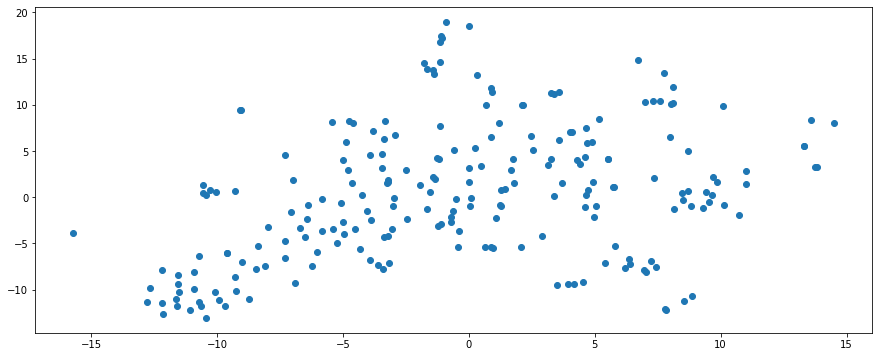

In [19]:
fig = plt.figure()
fig.set_size_inches(15, 6)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_df["x"], tsne_df["y"])

plt.show()

#### 3.2 군집개수 결정

###### 3.2.1 엘보우함수

엘보우: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  6.88it/s]


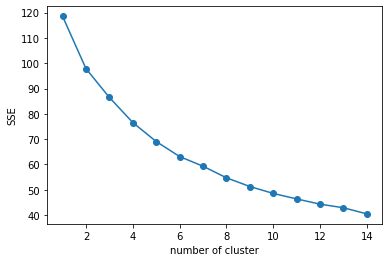

In [20]:
# 엘보우 함수로 군집 개수 결정

word_vectors = min_wage['문장벡터'].to_list() # 함수에 넣을 X값 지정
elbow(word_vectors)

###### 3.2.2 실루엣계수

In [21]:
def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    plt.axvline(silhoutte_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('K')
    plt.xlabel('silhouette')
    plt.show()

###### 3.2.3 군집의 개수를 변화시키며 시각화

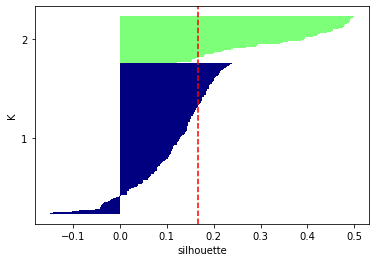

In [22]:
word_vectors = min_wage['문장벡터'].to_list()
k= 2

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=0)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

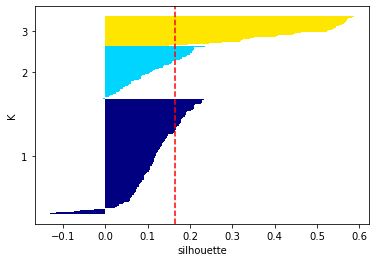

In [23]:
word_vectors = min_wage['문장벡터'].to_list()
k= 3

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=0)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

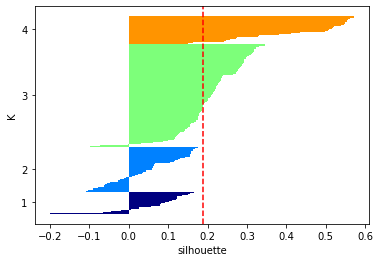

In [24]:
word_vectors = min_wage['문장벡터'].to_list()
k= 4

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=0)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

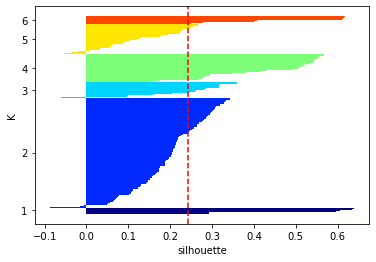

In [25]:
word_vectors = min_wage['문장벡터'].to_list()
k=6

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=0)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

#### 3.3 K-means 수행

In [26]:
# K means 수행 
word_vectors = min_wage['문장벡터'].to_list()
num_clusters = 6

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)
min_wage['category'] = idx

In [27]:
min_wage['category'].value_counts()

2    120
0     38
1     32
3     18
5      9
4      7
Name: category, dtype: int64

In [28]:
X = min_wage['문장벡터'].to_list()
y = min_wage['category'].to_list()

tsne_filepath = 'tsne3000.pkl'

tsne = TSNE(random_state=42)
tsne_points = tsne.fit_transform(X)

'''
# File Cache
if not os.path.exists(tsne_filepath):
    tsne = TSNE(random_state=42)
    tsne_points = tsne.fit_transform(X)
    with open(tsne_filepath, 'wb+') as f:
        pickle.dump(tsne_points, f)
else: # Cache Hits!
    with open(tsne_filepath, 'rb') as f:
        tsne_points = pickle.load(f)
'''

tsne_df = pd.DataFrame(tsne_points, index=range(len(X)), columns=['x_coord', 'y_coord'])
tsne_df['BillNo'] = min_wage['의안번호'].to_list()
tsne_df['BillName'] = min_wage['의안명'].to_list()
tsne_df['cluster_no'] = y

In [29]:
output_notebook()

Loading BokehJS ...

In [30]:
# 색 정해주기

colors = brewer["Paired"][len(tsne_df['cluster_no'].unique())]
colormap = {i: colors[i] for i in tsne_df['cluster_no'].unique()}
colors = [colormap[x] for x in tsne_df['cluster_no']]
tsne_df['color'] = colors

In [31]:
# Bokeh가 인식하는 DataSource 객체 만들어주기
plot_data = ColumnDataSource(
    data=tsne_df.to_dict(orient='list')
)

# Plot 만들기(배경)
tsne_plot = figure(
    title='minimum wage bill',
    plot_width = 650,
    plot_height = 650,
    active_scroll='wheel_zoom',
    output_backend="webgl", # GPU 가속
)

In [32]:
# 마우스 올렸을 때 보여줄 것

tsne_plot.add_tools(
    HoverTool(
        tooltips= '@BillName'
    )
)

# 데이터 정보 넣기

tsne_plot.circle(
    source=plot_data,
    x='x_coord',
    y='y_coord',
    line_alpha=0.3, 
    fill_alpha=0.2,
    size=10,
    fill_color='color',
    line_color='color',
)

# 선 지우기

tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None


show(tsne_plot)


빨간색  -> 기존 최저임금법 개정
파란색  -> 기존 최저임금법 개정    
하늘색  -> 최저임금과 관련된 조세 관련법
라임색  -> 사회적 약자를 위한 최저임금 관련법  
초록색  ->     
빨간색  -> 국가에서 지급하는 임금에 관한 법률    

In [139]:
min_wage['cat_name'] = ''

min_wage.loc[min_wage['category'] == 0, 'cat_name'] = '기존 최저임금법 개정'
min_wage.loc[min_wage['category'] == 1, 'cat_name'] = '기존 최저임금법 개정2'
min_wage.loc[min_wage['category'] == 2, 'cat_name'] = '사회적 약자를 위한 최저임금 관련법'
min_wage.loc[min_wage['category'] == 3, 'cat_name'] = '최저임금법 변화로 인한 조세 제도 관련법'
min_wage.loc[min_wage['category'] == 4, 'cat_name'] = '계약관계하의 최저임금 관련법'
min_wage.loc[min_wage['category'] == 5, 'cat_name'] = '최저임금위원회 관련법'

In [141]:
min_wage2 = pd.concat([min_wage, tsne_df], axis=1)
min_wage2.head()
#min_wage2[min_wage2['cluster_no']==0][:10]

,의안번호,의안명,의결결과,제안이유,법률공포여부,의안명+제안이유,tokens,명사수,문장벡터,category,cat_name,x_coord,y_coord,BillNo,BillName,cluster_no,color
0,2024811,부가가치세법 일부개정법률안,임기만료폐기,법은 직전 연도의 재화와 용역의 공급에 대한 대가의 합계액이 만원에 미달하는 개인...,미공포,부가가치세법 일부개정법률안 법은 직전 연도의 재화와 용역의 공급에 대한 대가의 합계...,"[부가가치, 세법, 일부, 개정, 법률, 직전, 연도, 재화, 용역, 공급, 대한,...",90,"[0.08843102, -0.011943505, -0.06128732, -0.052...",0,기존 최저임금법 개정,-7.668487,-9.459200,2024811,부가가치세법 일부개정법률안,0,#a6cee3
1,2024270,공직선거법 일부개정법률안,임기만료폐기,법은 예비후보자 및 후보자의 선거운동과 선거비용의 회계처리를 위해 선거사무장 선거사...,미공포,공직선거법 일부개정법률안 법은 예비후보자 및 후보자의 선거운동과 선거비용의 회계처리...,"[공직선거법, 일부, 개정, 법률, 예비, 후보자, 후보자, 선거운동, 선거, 비용...",112,"[-0.023237335, -0.035124034, 0.09654069, -0.01...",1,기존 최저임금법 개정2,2.765497,-3.316074,2024270,공직선거법 일부개정법률안,1,#1f78b4
2,2023868,국회의원수당 등에 관한 법률 일부개정법률안,임기만료폐기,년 현재 국회의원에게 연간 지급되는 세비는 일반수당 관리업무수당 정액급식비 정...,미공포,국회의원수당 등에 관한 법률 일부개정법률안 년 현재 국회의원에게 연간 지급되는 세비...,"[국회의원, 수당, 법률, 일부, 개정, 법률, 현재, 국회의원, 연간, 지급, 세...",156,"[-0.007320973, -0.051181052, 0.035989866, -0.0...",1,기존 최저임금법 개정2,-1.104472,3.426414,2023868,국회의원수당 등에 관한 법률 일부개정법률안,1,#1f78b4
3,2023763,부가가치세법 일부개정법률안,대안반영폐기,산물 의제매입세액 공제제도는 제조 외식업 사업자가 부가가치세가 면세되는 농수산물을 ...,미공포,부가가치세법 일부개정법률안 산물 의제매입세액 공제제도는 제조 외식업 사업자가 부가가...,"[부가가치, 세법, 일부, 개정, 법률, 산물, 의제, 매입, 세액, 제도, 제조,...",96,"[0.035696622, 0.006894637, -0.043259427, 0.028...",0,기존 최저임금법 개정,-2.632847,-0.947121,2023763,부가가치세법 일부개정법률안,0,#a6cee3
4,2023518,소득세법 일부개정법률안,임기만료폐기,법은 일용근로자의 세부담을 완화하기 위하여 일용근로자의 일급에서 일 만원을 정액으로...,미공포,소득세법 일부개정법률안 법은 일용근로자의 세부담을 완화하기 위하여 일용근로자의 일급...,"[소득, 세법, 일부, 개정, 법률, 일용, 근로자, 부담, 완화, 일용, 근로자,...",65,"[-0.031527292, 0.021431847, -0.057491906, -0.0...",0,기존 최저임금법 개정,-1.985365,-5.528087,2023518,소득세법 일부개정법률안,0,#a6cee3


#### 3.4 각 카테고리별 공포 여부 확인

In [81]:
pd.pivot_table(data = min_wage2, index = ['cat_name', '법률공포여부'], values = ['의안명'], aggfunc='count')

의안명
cat_name            법률공포여부     
국가에서 지급하는 임금에 관한 법률 공포        1
                    미공포      39
기존 최저임금법 개정         공포        1
                    미공포      67
기존 최저임금법 개정2        공포        1
                    미공포      25
사회적 약자를 위한 최저임금 관련법 미공포       2
최저임금으로 인한 조세제도 개정   공포        2
                    미공포      46

In [82]:
#keyword = r'.*(최저임금).*'
keyword = r'.*(국가).*'
min_wage_a = min_wage[min_wage['의안명'].str.match(keyword) |
           min_wage['제안이유'].str.match(keyword, flags=re.MULTILINE)]
min_wage_a = min_wage_a.reset_index()
min_wage_a = min_wage_a.drop('index',1)
min_wage_a.head()

,의안번호,의안명,의결결과,제안이유,법률공포여부,의안명+제안이유,tokens,명사수,문장벡터,category,cat_name
0,2020875,근로기준법 일부개정법률안,임기만료폐기,세 미만인 연소자의 근로가 계속 증가하고 있는데 이들은 주로 소규모 사업장에서 단...,미공포,근로기준법 일부개정법률안 세 미만인 연소자의 근로가 계속 증가하고 있는데 이들은 ...,"[근로기준법, 일부, 개정, 법률, 미만, 연소자, 근로, 계속, 증가, 주로, 소...",60,"[-0.037304543, 0.021372652, -0.017548451, 0.04...",4,국가에서 지급하는 임금에 관한 법률
1,2020542,조세특례제한법 일부개정법률안,임기만료폐기,년 분기 경제성장률이 전기 대비 가 감소하면서 금융위기를 겪었던 년 분기 이후 ...,미공포,조세특례제한법 일부개정법률안 년 분기 경제성장률이 전기 대비 가 감소하면서 금융...,"[특례, 일부, 개정, 법률, 분기, 경제성장률, 전기, 대비, 감소, 금융위기, ...",249,"[0.0068700123, 0.010682258, 0.08675907, 0.0003...",3,사회적 약자를 위한 최저임금 관련법
2,2020541,법인세법 일부개정법률안,임기만료폐기,년 분기 경제성장률이 전기 대비 가 감소하면서 금융위기를 겪었던 년 분기 이후 ...,미공포,법인세법 일부개정법률안 년 분기 경제성장률이 전기 대비 가 감소하면서 금융위기를...,"[법인, 세법, 일부, 개정, 법률, 분기, 경제성장률, 전기, 대비, 감소, 금융...",266,"[-0.024024317, 0.015062795, 0.08117904, -0.020...",3,사회적 약자를 위한 최저임금 관련법
3,2020438,장애인고용촉진 및 직업재활법 일부개정법률안,임기만료폐기,장애인복지법 에 따른 보호고용시설인 직업재활시설은 장애인복지법 에 따라 설립 지...,미공포,장애인고용촉진 및 직업재활법 일부개정법률안 장애인복지법 에 따른 보호고용시설인 ...,"[장애인, 고용, 촉진, 직업, 재활, 일부, 개정, 법률, 장애, 인복, 지법, ...",229,"[-0.026919378, 0.03210599, 0.015159306, -0.027...",2,기존 최저임금법 개정2
4,2018932,아동복지법 일부개정법률안,임기만료폐기,법은 아동복지시설이나 가정위탁 보호를 받고 있는 보호대상아동이 세가 되어 보호가 종...,미공포,아동복지법 일부개정법률안 법은 아동복지시설이나 가정위탁 보호를 받고 있는 보호대상아...,"[아동복지법, 일부, 개정, 법률, 아동복, 시설, 가정위탁, 보호, 보호대, 아동...",73,"[0.016473763, 0.062865935, 0.02066994, 0.01597...",2,기존 최저임금법 개정2


In [138]:
min_wage2[min_wage2['category']==5]

,의안번호,의안명,의결결과,제안이유,법률공포여부,의안명+제안이유,tokens,명사수,문장벡터,category,cat_name,x_coord,y_coord,BillNo,BillName,cluster_no,color
29,2018877,최저임금법 일부개정법률안,임기만료폐기,임금이 우리사회와 경제에 미치는 영향이 커지고 있는 상황을 고려할 때 최저임금 결정...,미공포,최저임금법 일부개정법률안 임금이 우리사회와 경제에 미치는 영향이 커지고 있는 상황을...,"[최저임금법, 일부, 개정, 법률, 임금, 우리, 사회, 경제, 영향, 상황, 고려...",474,"[0.012717103, -0.16645229, 0.100949824, 0.0272...",5,국가에서 지급하는 임금에 관한 법률,-9.072631,16.908720,2018877,최저임금법 일부개정법률안,5,#e31a1c
33,2018696,최저임금법 일부개정법률안,임기만료폐기,임금위원회는 사용자위원과 근로자위원의 갈등으로 파행되는 경우가 많아 공익위원의 의견...,미공포,최저임금법 일부개정법률안 임금위원회는 사용자위원과 근로자위원의 갈등으로 파행되는 경...,"[최저임금법, 일부, 개정, 법률, 임금, 위원회, 사용자, 위원, 근로자, 위원,...",98,"[0.036864176, -0.22184539, 0.16793308, 0.01734...",5,국가에서 지급하는 임금에 관한 법률,-8.953203,19.279581,2018696,최저임금법 일부개정법률안,5,#e31a1c
35,2018257,최저임금법 일부개정법률안,임기만료폐기,최저임금위원회는 근로자위원 사용자위원 공익위원이 각각 명으로 구성되어 운영됨에...,미공포,최저임금법 일부개정법률안 최저임금위원회는 근로자위원 사용자위원 공익위원이 각각...,"[최저임금법, 일부, 개정, 법률, 최저임금, 위원회, 근로자, 위원, 사용자, 위...",143,"[0.025548497, -0.1815831, 0.123345286, 0.00926...",5,국가에서 지급하는 임금에 관한 법률,-8.127820,19.442451,2018257,최저임금법 일부개정법률안,5,#e31a1c
54,2015435,최저임금법 일부개정법률안,임기만료폐기,법에서는 최저임금을 사업의 종류별로 구분할 수 있다고 규정되어 있으나 실질적인 효과...,미공포,최저임금법 일부개정법률안 법에서는 최저임금을 사업의 종류별로 구분할 수 있다고 규정...,"[최저임금법, 일부, 개정, 법률, 최저임금, 사업, 종류, 별로, 분할, 규정, ...",88,"[0.0020971035, -0.15207526, 0.0972803, 0.01083...",5,국가에서 지급하는 임금에 관한 법률,-7.862721,17.871531,2015435,최저임금법 일부개정법률안,5,#e31a1c
58,2015310,최저임금법 일부개정법률안,임기만료폐기,업이 생산하는 농축수산물은 공산품과 달리 생산자가 스스로 가격을 결정할 수 없는 특...,미공포,최저임금법 일부개정법률안 업이 생산하는 농축수산물은 공산품과 달리 생산자가 스스로 ...,"[최저임금법, 일부, 개정, 법률, 생산, 농축, 수산물, 공산품, 달리, 생산자,...",76,"[0.0049999165, -0.08072407, 0.06789807, 0.0071...",5,국가에서 지급하는 임금에 관한 법률,-7.408140,15.793891,2015310,최저임금법 일부개정법률안,5,#e31a1c
59,2015301,최저임금법 일부개정법률안,임기만료폐기,최저임금법 과 최저임금법 시행령 에 따르면 최저임금을 심의하는 최저임금위원회는...,미공포,최저임금법 일부개정법률안 최저임금법 과 최저임금법 시행령 에 따르면 최저임금을...,"[최저임금법, 일부, 개정, 법률, 최저임금법, 최저임금법, 시행, 최저임금, 심의...",93,"[0.049666513, -0.141476, 0.038370714, 0.016386...",5,국가에서 지급하는 임금에 관한 법률,-10.204600,18.851488,2015301,최저임금법 일부개정법률안,5,#e31a1c
63,2015137,국회법 일부개정법률안,임기만료폐기,법상 최저임금은 고용노동부에 설치된 최저임금위원회가 심의 또는 재심의하여 의결한 최...,미공포,국회법 일부개정법률안 법상 최저임금은 고용노동부에 설치된 최저임금위원회가 심의 또는...,"[국회법, 일부, 개정, 법률, 최저임금, 고용노동부, 설치, 최저임금, 위원회, ...",88,"[0.014429051, -0.13265951, 0.109201394, 0.0573...",5,국가에서 지급하는 임금에 관한 법률,-10.244977,14.723928,2015137,국회법 일부개정법률안,5,#e31a1c
64,2015126,최저임금법 일부개정법률안,임기만료폐기,법상 최저임금은 최저임금위원회가 심의 또는 재심의하여 의결한 최저임금안에 따라 고용...,미공포,최저임금법 일부개정법률안 법상 최저임금은 최저임금위원회가 심의 또는 재심의하여 의결...,"[최저임금법, 일부, 개정, 법률, 최저임금, 최저임금, 위원회, 심의, 재심, 의...",62,"[0.0025385888, -0.1810355, 0.13281976, 0.06421...",5,국가에서 지급하는 임금에 관한 법률,-9.684001,15.156471,2015126,최저임금법 일부개정법률안,5,#e31a1c
65,2015033,최저임금법 일부개정법률안,임기만료폐기,임금위원회는 최저임금 심의에 필요한 근로자의 임금실태 파악을 위하여 고용형태별 실태...,미공포,최저임금법 일부개정법률안 임금위원회는 최저임금 심의에 필요한 근로자의 임금실태 파악...,"[최저임금법, 일부, 개정, 법률, 임금, 위원회, 최저임금, 심의, 근로자, 임금...",61,"[-0.01661393, -0.08611905, 0.057155833, 0.0500...",5,국가에서 지급하는 임금에 관한 법률,-4.809687,11.949967,2015033,최저임금법 일부개정법률안,5,#e31a1c
67,2014922,최저임금법 일부개정법률안,임기만료폐기,임금의 결정은 우리 사회에 커다란 영향을 가져오는 정책적 결정이므로 경제성장 물가...,미공포,최저임금법 일부개정법률안 임금의 결정은 우리 사회에 커다란 영향을 가져오는 정책적 ...,"[최저임금법, 일부, 개정, 법률, 임금, 결정, 우리, 사회, 영향, 정책, 결정...",253,"[0.021691857, -0.1709713, 0.13223097, 0.004264...",5,국가에서 지급하는 임금에 관한 법률,-7.520962,18.719355,2014922,최저임금법 일부개정법률안,5,#e31a1c


## 4. WordCloud

In [83]:
stopwords_list = ['법률', '경우', '대한', '일부', '개정','것임', '관련','현행법','위원회','조의',\
                  '조제', '관련', '내용', '사항', '발생', '행위', '운영', '업무','이상', '신설', '규정',\
                  '사업', '해당', '기준', '마련', '설치', '사항', '대상', '또는', '있음']

In [122]:
from collections import Counter
import matplotlib
from IPython.display import set_matplotlib_formats
def wordcloud(text_list, cluster_num):
    
    okt = Okt()
    morphs = []
    nv = []
    
    for sentence in text_list:
        morphs.append(okt.pos(sentence))
    
    # 명사, 동사만 & 추가 조건
    for sentence in morphs:
        for word, tag in sentence:
            if (tag == ('Noun' or 'Verb')) and (len(word)!=1):
                nv.append(word)
                
    unique_Noun_words = set(nv)
    for word in unique_Noun_words:
        if word in stopwords_list:
            while word in nv: nv.remove(word)  # 최종결과 : Noun_words
                
    # 빈도수 정렬
    count = Counter(nv)
    wordfreq = dict(count.most_common())
    

    
    # 디스플레이 설정
    
    matplotlib.rc('font',family = 'NanumBarunGothic') 
    set_matplotlib_formats('retina') 
    matplotlib.rc('axes',unicode_minus = False)
    fig = plt.figure(figsize=(10, 10))

    wordcloud = WordCloud(font_path = 'C:/Users/NK/AppData/Local/Microsoft/Windows/Fonts/BlackHanSans-Regular.ttf',
                          background_color='black',colormap = "Accent_r",
                          stopwords = stopwords_list,
                          width=5000, height=3000).generate_from_frequencies(wordfreq) 
    plt.imshow(wordcloud) 
    plt.axis('off')
    plt.figure(figsize=(10, 10))
    plt.show()
    
    fig.savefig(f'cluster{cluster_num}.png')

    return wordfreq

In [123]:
cluster0 = min_wage2[min_wage2['cluster_no'] == 0]
cluster1 = min_wage2[min_wage2['cluster_no'] == 1]
cluster2 = min_wage2[min_wage2['cluster_no'] == 2]
cluster3 = min_wage2[min_wage2['cluster_no'] == 3]
cluster4 = min_wage2[min_wage2['cluster_no'] == 4]
cluster5 = min_wage2[min_wage2['cluster_no'] == 5]

In [124]:
min_wage2['cluster_no'].value_counts()

1    81
0    58
5    31
2    29
4    18
3     7
Name: cluster_no, dtype: int64

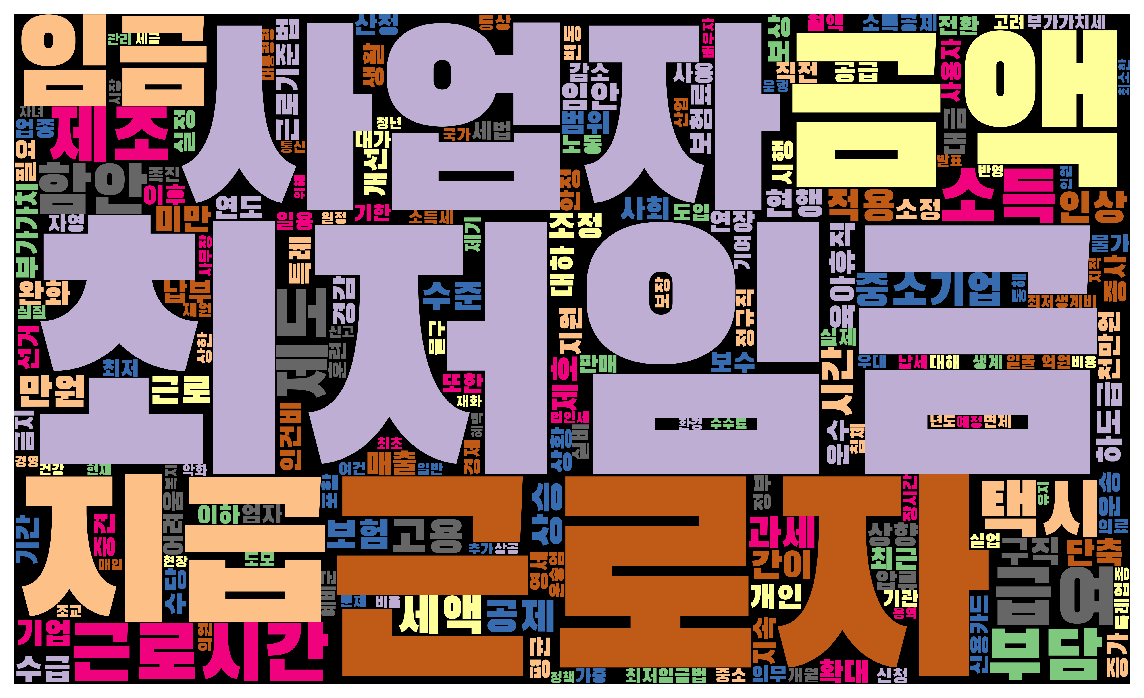

<Figure size 720x720 with 0 Axes>

{'최저임금': 83,
 '근로자': 83,
 '사업자': 71,
 '금액': 69,
 '지급': 67,
 '임금': 66,
 '근로시간': 62,
 '급여': 60,
 '택시': 58,
 '제조': 56,
 '소득': 54,
 '부담': 49,
 '제도': 48,
 '함안': 47,
 '세액': 46,
 '중소기업': 46,
 '고용': 45,
 '적용': 41,
 '공제': 40,
 '시간': 40,
 '인상': 39,
 '만원': 38,
 '과세': 38,
 '상승': 36,
 '보험': 34,
 '간이': 31,
 '근로': 31,
 '수준': 31,
 '구직': 30,
 '임안': 29,
 '현행': 29,
 '단축': 28,
 '기업': 26,
 '미만': 26,
 '제호': 26,
 '조정': 26,
 '수급': 26,
 '하도급': 25,
 '육아휴직': 24,
 '개인': 23,
 '완화': 23,
 '매출': 22,
 '범위': 22,
 '사회': 22,
 '상향': 21,
 '확대': 21,
 '대하': 21,
 '연도': 20,
 '납부': 20,
 '지속': 20,
 '경감': 20,
 '종사': 20,
 '개선': 20,
 '기간': 20,
 '지원': 20,
 '근로기준법': 20,
 '부가가치': 19,
 '최근': 19,
 '보험료': 19,
 '특례': 19,
 '보상': 19,
 '대금': 19,
 '인건비': 18,
 '천만원': 18,
 '소정': 18,
 '운수': 18,
 '운송': 18,
 '수당': 18,
 '공급': 17,
 '상황': 17,
 '연장': 17,
 '증가': 17,
 '보수': 17,
 '산정': 17,
 '시행': 17,
 '중견': 17,
 '실정': 17,
 '선거': 17,
 '직전': 16,
 '이후': 16,
 '어려움': 16,
 '필요': 16,
 '생활': 16,
 '안정': 16,
 '평균': 16,
 '이하': 15,
 '사용자': 15,
 '사용': 15,
 '금지': 15,


In [125]:
wordcloud(cluster0['의안명+제안이유'], 0)

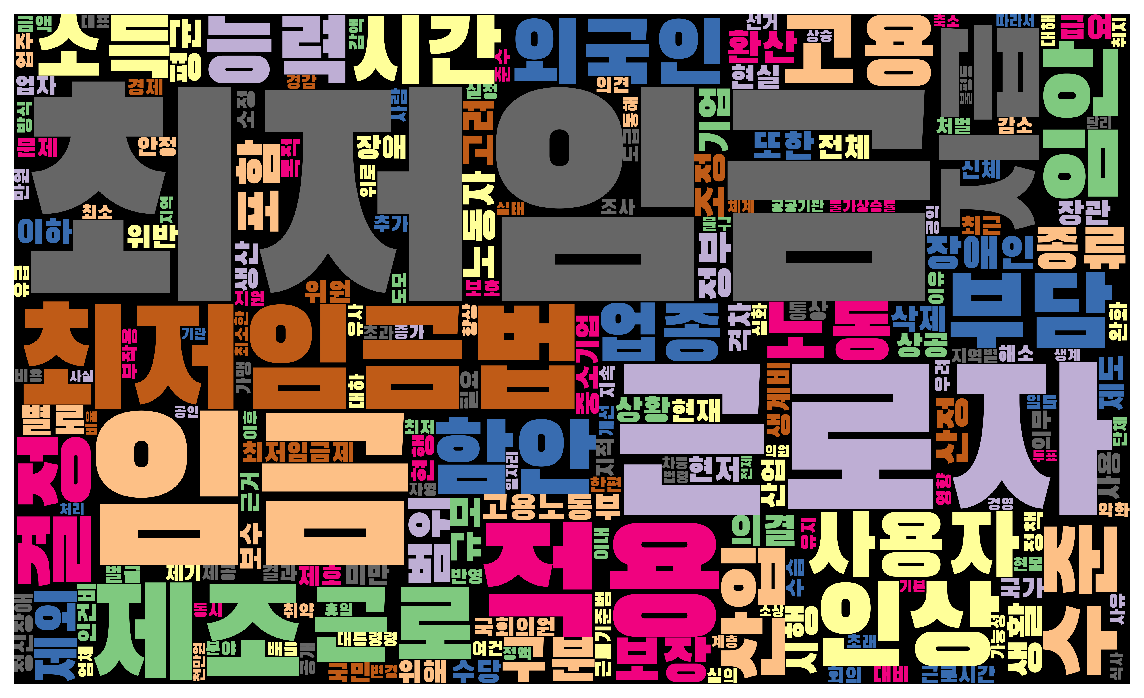

<Figure size 720x720 with 0 Axes>

{'최저임금': 523,
 '임금': 229,
 '근로자': 225,
 '적용': 115,
 '최저임금법': 111,
 '지급': 101,
 '제조': 96,
 '인상': 72,
 '부담': 57,
 '근로': 57,
 '함안': 56,
 '임안': 55,
 '수준': 53,
 '결정': 53,
 '고용': 51,
 '시간': 47,
 '능력': 46,
 '외국인': 43,
 '사용자': 42,
 '소득': 40,
 '산입': 40,
 '노동': 39,
 '업종': 38,
 '구분': 38,
 '보장': 38,
 '종류': 35,
 '포함': 35,
 '제외': 35,
 '범위': 34,
 '장애인': 33,
 '생활': 33,
 '노동자': 32,
 '환산': 31,
 '정부': 31,
 '시행': 31,
 '산정': 30,
 '고려': 29,
 '평균': 28,
 '의결': 28,
 '기업': 28,
 '규모': 28,
 '조정': 28,
 '별로': 28,
 '또한': 24,
 '고용노동부': 24,
 '삭제': 24,
 '제도': 24,
 '상황': 24,
 '이하': 24,
 '급여': 23,
 '현저': 23,
 '장관': 22,
 '전체': 22,
 '상공': 22,
 '위반': 21,
 '현실': 20,
 '생계비': 20,
 '장애': 20,
 '산업': 20,
 '중소기업': 20,
 '위해': 19,
 '수당': 19,
 '현재': 19,
 '격차': 19,
 '사용': 19,
 '생산': 19,
 '보수': 18,
 '위원': 18,
 '현행': 18,
 '최저임금제': 18,
 '미만': 18,
 '국민': 17,
 '제호': 17,
 '국가': 17,
 '국회의원': 16,
 '업자': 16,
 '문제': 16,
 '최근': 16,
 '안정': 16,
 '의무': 16,
 '목적': 16,
 '정책': 16,
 '근거': 16,
 '지적': 15,
 '통상': 15,
 '정신장애': 15,
 '신체': 15,
 '완화': 15,
 '수

In [126]:
wordcloud(cluster1['의안명+제안이유'],1)

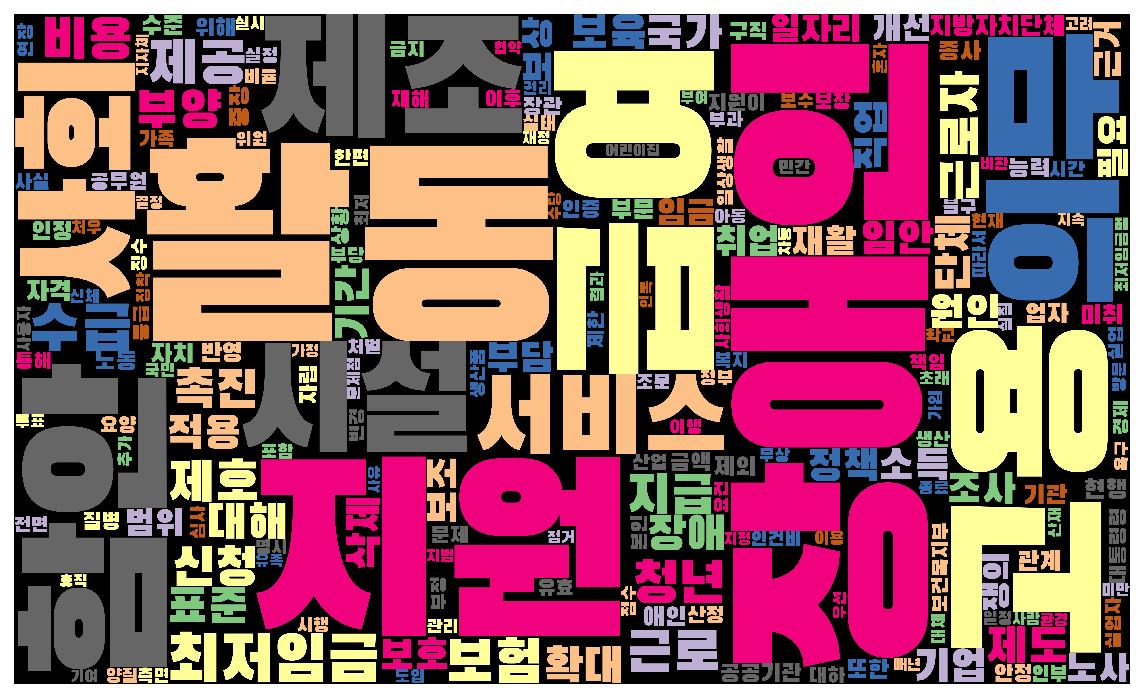

<Figure size 720x720 with 0 Axes>

{'활동': 147,
 '장애인': 145,
 '지원': 120,
 '고용': 93,
 '급여': 93,
 '함안': 76,
 '의무': 63,
 '제조': 63,
 '사회': 56,
 '시설': 52,
 '서비스': 51,
 '최저임금': 48,
 '수급': 45,
 '제공': 40,
 '보험': 39,
 '청년': 37,
 '근로': 36,
 '비용': 35,
 '제호': 34,
 '지급': 32,
 '근로자': 31,
 '신청': 31,
 '촉진': 30,
 '부양': 30,
 '표준': 27,
 '제도': 27,
 '확대': 26,
 '대해': 26,
 '장애': 25,
 '보육': 24,
 '국가': 24,
 '단체': 24,
 '적용': 23,
 '기간': 23,
 '임안': 22,
 '삭제': 22,
 '기업': 22,
 '원인': 22,
 '직업': 21,
 '정책': 21,
 '소득': 21,
 '보호': 20,
 '조사': 20,
 '부담': 19,
 '보조': 19,
 '취업': 19,
 '보상': 19,
 '필요': 19,
 '재활': 18,
 '노사': 18,
 '일자리': 17,
 '근거': 16,
 '범위': 16,
 '개선': 16,
 '쟁의': 16,
 '임금': 16,
 '지방자치단체': 16,
 '자격': 16,
 '애인': 15,
 '자치': 15,
 '부문': 15,
 '관계': 15,
 '현행': 15,
 '기관': 15,
 '종사': 15,
 '미취': 15,
 '업자': 15,
 '증장': 14,
 '반영': 14,
 '또한': 14,
 '노동': 14,
 '능력': 14,
 '제외': 14,
 '인정': 14,
 '수준': 14,
 '위해': 13,
 '금액': 13,
 '공공기관': 13,
 '안정': 12,
 '인증': 12,
 '장관': 12,
 '자립': 12,
 '지원이': 12,
 '구직': 12,
 '문제': 11,
 '재해': 11,
 '질병': 11,
 '공무원': 11,
 '대통령령': 11,
 '

In [127]:
wordcloud(cluster2['의안명+제안이유'],2)

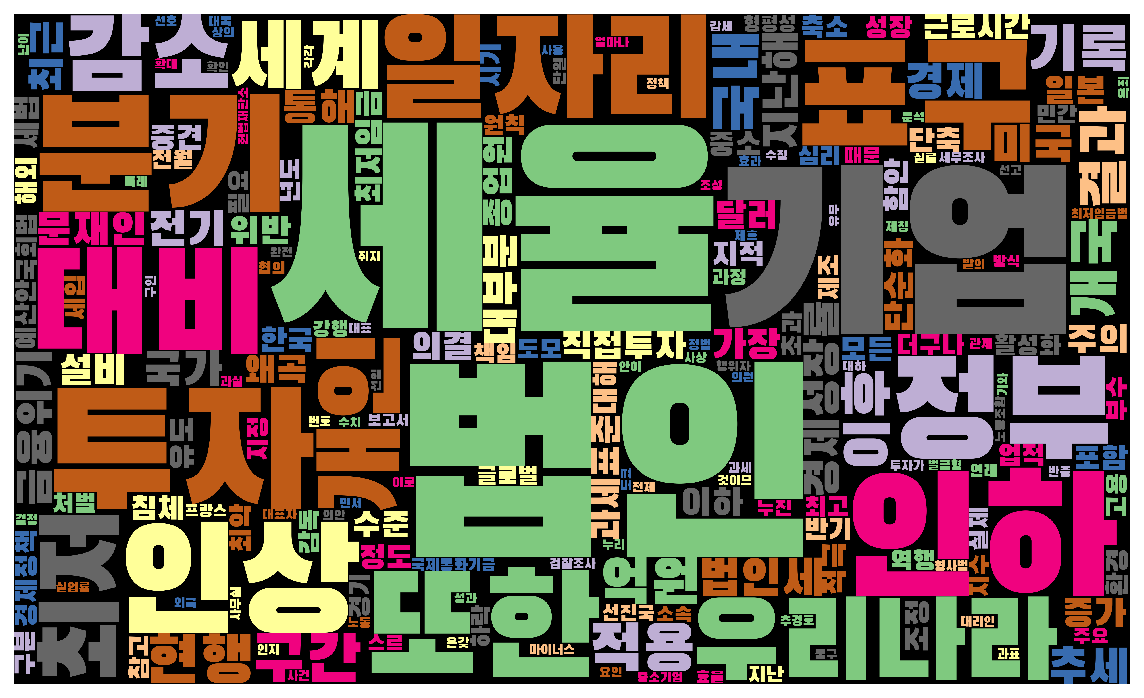

<Figure size 720x720 with 0 Axes>

{'세율': 58,
 '법인': 51,
 '기업': 37,
 '인하': 18,
 '투자': 17,
 '분기': 16,
 '인상': 14,
 '표구': 14,
 '대비': 13,
 '또한': 13,
 '일자리': 13,
 '정부': 13,
 '우리나라': 13,
 '개인': 13,
 '최저': 12,
 '감소': 11,
 '세계': 11,
 '현행': 11,
 '적용': 11,
 '구간': 11,
 '이후': 10,
 '기록': 10,
 '국내': 10,
 '결과': 10,
 '억원': 10,
 '개국': 10,
 '법인세': 9,
 '미국': 9,
 '경제성장률': 8,
 '전기': 8,
 '금융위기': 8,
 '지난해': 8,
 '국가': 8,
 '경제': 8,
 '추세': 8,
 '대부분': 7,
 '통해': 7,
 '문재인': 7,
 '최근': 7,
 '가장': 6,
 '설비': 6,
 '직접투자': 6,
 '증가': 6,
 '일본': 6,
 '단순화': 6,
 '과세표준': 6,
 '이하': 6,
 '의결': 6,
 '왜곡': 6,
 '종업원': 6,
 '위반': 6,
 '주의': 6,
 '달러': 6,
 '수준': 5,
 '최저임금': 5,
 '근로시간': 5,
 '단축': 5,
 '지적': 5,
 '한국': 5,
 '침체': 5,
 '정도': 5,
 '중소': 5,
 '중견': 5,
 '포함': 5,
 '모든': 5,
 '적극': 5,
 '유도': 5,
 '조정': 5,
 '함안': 5,
 '세법': 5,
 '대해': 5,
 '성장': 4,
 '축소': 4,
 '반기': 4,
 '업적': 4,
 '경제정책': 4,
 '최악': 4,
 '해외': 4,
 '환경': 4,
 '더구나': 4,
 '활성화': 4,
 '도모': 4,
 '시기': 4,
 '역행': 4,
 '최고': 4,
 '고용': 4,
 '경기': 4,
 '참고': 4,
 '국회법': 4,
 '제조': 4,
 '년도': 4,
 '세입': 4,
 '예산안': 4,
 '부수': 4,
 '지정':

In [128]:
wordcloud(cluster3['의안명+제안이유'],3)

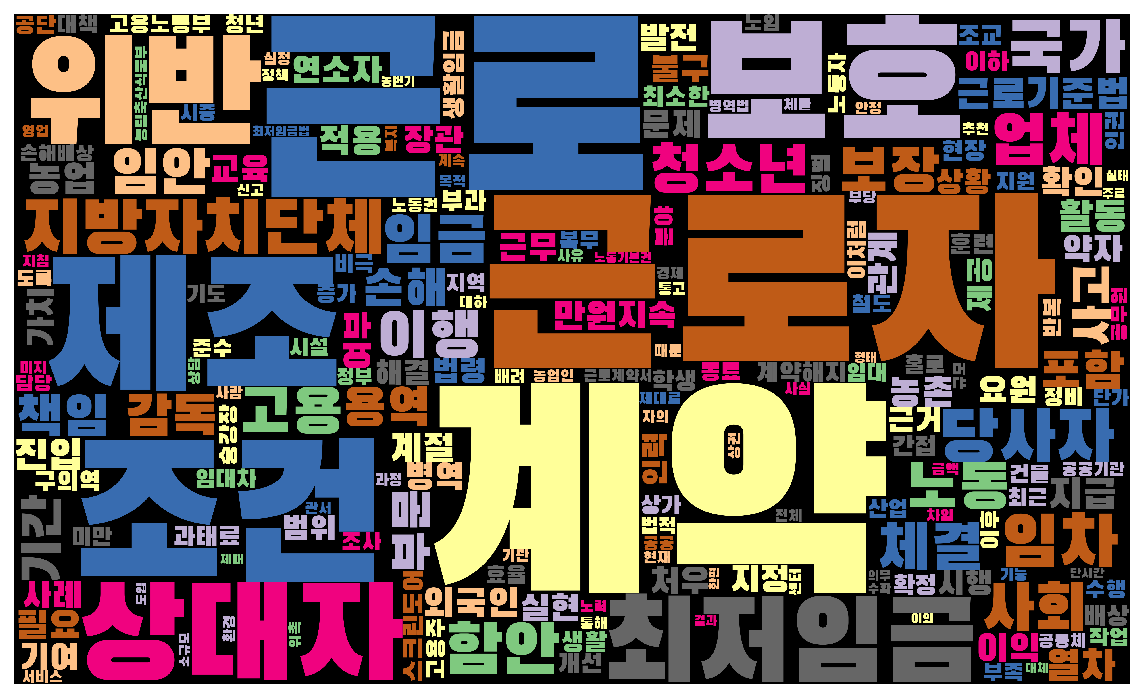

<Figure size 720x720 with 0 Axes>

{'계약': 90,
 '근로': 67,
 '근로자': 61,
 '조건': 39,
 '제조': 35,
 '보호': 28,
 '위반': 22,
 '상대자': 21,
 '최저임금': 19,
 '지방자치단체': 19,
 '국가': 18,
 '임차': 18,
 '당사자': 18,
 '업체': 17,
 '함안': 17,
 '임금': 15,
 '사회': 15,
 '청소년': 15,
 '이행': 14,
 '체결': 14,
 '노동': 14,
 '고용': 14,
 '보장': 13,
 '임안': 13,
 '감독': 11,
 '책임': 11,
 '기간': 10,
 '용역': 10,
 '손해': 9,
 '사고': 9,
 '부문': 9,
 '포함': 9,
 '근로기준법': 8,
 '활동': 8,
 '농업': 8,
 '지급': 8,
 '열차': 8,
 '진입': 8,
 '필요': 7,
 '관계': 7,
 '적용': 7,
 '외국인': 7,
 '계절': 7,
 '농촌': 7,
 '확인': 7,
 '만원': 7,
 '이익': 7,
 '연소자': 6,
 '근무': 6,
 '장관': 6,
 '기여': 6,
 '요원': 6,
 '병역': 6,
 '지정': 6,
 '불구': 6,
 '문제': 6,
 '지속': 6,
 '발전': 6,
 '여부': 6,
 '약자': 6,
 '사례': 6,
 '교육': 6,
 '처우': 6,
 '가치': 6,
 '실현': 6,
 '상황': 5,
 '법령': 5,
 '인력': 5,
 '해결': 5,
 '근거': 5,
 '시행': 5,
 '범위': 5,
 '제공': 5,
 '계약해지': 5,
 '배상': 5,
 '학생': 5,
 '조교': 5,
 '구의역': 5,
 '스크린도어': 5,
 '간접': 5,
 '최소한': 5,
 '생활': 5,
 '확정': 5,
 '이하': 5,
 '과태료': 5,
 '부과': 5,
 '훈련': 5,
 '현장': 5,
 '개선': 5,
 '생활임금': 5,
 '미만': 4,
 '증가': 4,
 '대책': 4,
 '고용노동부': 4,
 '지원

In [129]:
wordcloud(cluster4['의안명+제안이유'],4)

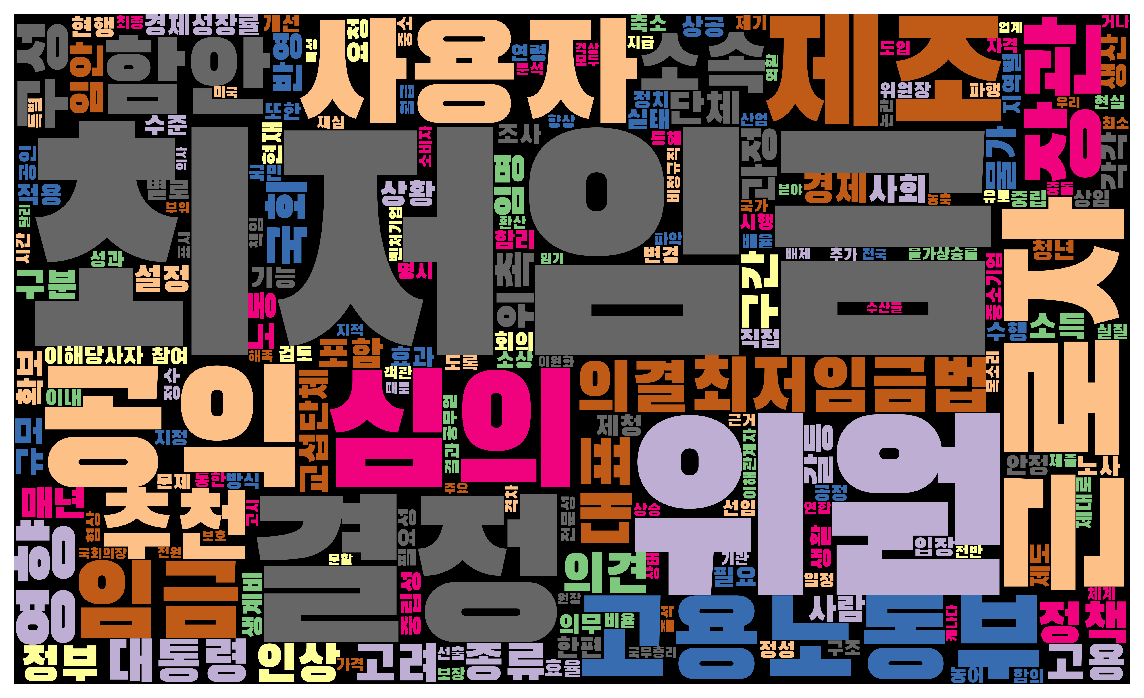

<Figure size 720x720 with 0 Axes>

{'최저임금': 328,
 '위원': 197,
 '결정': 123,
 '공익': 82,
 '근로자': 80,
 '심의': 76,
 '제조': 73,
 '사용자': 64,
 '고용노동부': 52,
 '임금': 44,
 '함안': 43,
 '장관': 42,
 '추천': 40,
 '소속': 38,
 '영향': 37,
 '최저임금법': 35,
 '의결': 31,
 '구성': 30,
 '대표': 30,
 '대통령': 30,
 '정책': 28,
 '의견': 26,
 '국회': 26,
 '고려': 24,
 '인상': 24,
 '종류': 23,
 '고용': 22,
 '위촉': 22,
 '구간': 21,
 '정부': 21,
 '과정': 20,
 '임안': 18,
 '단체': 17,
 '매년': 15,
 '경제': 14,
 '포함': 14,
 '임명': 14,
 '물가': 14,
 '갈등': 13,
 '구분': 13,
 '교섭단체': 13,
 '반영': 13,
 '사회': 12,
 '노동': 12,
 '규모': 12,
 '설정': 11,
 '소득': 11,
 '사람': 11,
 '확보': 11,
 '각각': 11,
 '상황': 10,
 '생산': 10,
 '경제성장률': 10,
 '요청': 10,
 '기능': 10,
 '적용': 10,
 '제청': 10,
 '한편': 10,
 '생활': 9,
 '안정': 9,
 '제도': 9,
 '현재': 9,
 '현행': 9,
 '수준': 9,
 '생계비': 9,
 '조사': 9,
 '청년': 9,
 '상공': 9,
 '중립성': 9,
 '필요': 9,
 '노사': 9,
 '별로': 9,
 '효과': 9,
 '의무': 9,
 '실태': 9,
 '합리': 8,
 '수행': 8,
 '회의': 8,
 '입장': 8,
 '지역별': 8,
 '직접': 8,
 '이해당사자': 8,
 '필요성': 8,
 '효율': 7,
 '참여': 7,
 '개선': 7,
 '정성': 7,
 '이내': 7,
 '상임': 7,
 '명시': 7,
 '정치': 7,
 '변경':

In [130]:
wordcloud(cluster5['의안명+제안이유'],5)